In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Input, Dropout
from keras.models import Sequential, Model
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import cohen_kappa_score
from keras.utils import to_categorical
# import os
# print([f for f in os.listdir("../input") if not f.startswith('.')])

Using TensorFlow backend.


In [0]:
train = pd.read_csv('/content/drive/My Drive/train.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')

In [0]:
train.id_code = train.id_code.apply(lambda x: x + ".png")
test.id_code = test.id_code.apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')

# Define how to crop images

In [0]:
def crop_image_from_gray(img, tol=7):
    
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (300, 300))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

# split training data into train and validation data

In [0]:
train_datagen = ImageDataGenerator(rescale=1. / 128, 
                                         validation_split=0.2,
                                         horizontal_flip=True,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         rotation_range=40, 
                                         zoom_range=0.15, 
                                         shear_range=0.15,
                                         preprocessing_function=preprocess_image,
                                         fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory="/content/train_images",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=12,
                                                    class_mode="categorical",
                                                    target_size=(300, 300),
                                                    subset='training')
                                                    
valid_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory="/content/train_images",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=12,
                                                    class_mode="categorical",
                                                    target_size=(300, 300),
                                                    subset='validation')  

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


# load model

In [0]:
conv_base = ResNet50(weights='/content/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False,input_shape=(300, 300, 3)) 
conv_base.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
model = Sequential() 
model.add(conv_base) 
model.add(GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(5, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
conv_base.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_50 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                

# warm up the model

In [0]:
learning_rate = 1E-3 

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [0]:
history = model.fit_generator(train_generator,\
                              steps_per_epoch=len(train)*0.8//12,\
                              epochs=2)
                              #callbacks=[qwk]
                            #   validation_data=valid_generator,\
                            #  validation_steps=len(train)*0.2//12)  

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
244/244 [==============================] - 443s 2s/step - loss: 0.8969 - acc: 0.6803
Epoch 2/2
244/244 [==============================] - 438s 2s/step - loss: 0.7887 - acc: 0.7159


# define callback metrix

In [0]:
def get_preds_and_labels(model, generator):
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / 12))):
        x, y = next(generator)
        preds.append(np.argmax(model.predict(x),axis=1))
        for i in y:
          labels.append(np.argmax(i))
        
    return np.concatenate(preds).ravel(), np.asarray(labels)

In [0]:
class Metrics(Callback):
    
    def on_train_begin(self, logs={}):
        
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        
        y_pred, labels = get_preds_and_labels(model, valid_generator)
        #y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        
        _val_kappa = cohen_kappa_score(labels, y_pred,labels=[0,1,2,3,4], weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('/content/drive/My Drive/resnet50-4.h5')
        return

# train model

In [0]:
for layer in model.layers:
    layer.trainable = True
    
kappa_metrics = Metrics()
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, min_lr=1e-6)

callback_list = [kappa_metrics,es, rlrop]
learning_rate = 1E-4 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_50 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                

In [0]:
history_finetunning = model.fit_generator(train_generator,
                              steps_per_epoch=len(train)*0.8//12,
                              validation_data=valid_generator,
                              validation_steps=len(train)*0.2//12,
                              epochs=50,
                              callbacks=callback_list)
#model_res.save('/content/drive/My Drive/resnet50-2.h5')

Epoch 1/50
244/244 [==============================] - 597s 2s/step - loss: 0.7044 - acc: 0.7411 - val_loss: 0.8159 - val_acc: 0.7391
val_kappa: 0.8055
Validation Kappa has improved. Saving model.
Epoch 2/50
244/244 [==============================] - 570s 2s/step - loss: 0.5911 - acc: 0.7841 - val_loss: 0.9355 - val_acc: 0.7172
val_kappa: 0.8408
Validation Kappa has improved. Saving model.
Epoch 3/50
244/244 [==============================] - 574s 2s/step - loss: 0.5544 - acc: 0.7927 - val_loss: 0.6417 - val_acc: 0.7869
val_kappa: 0.8721
Validation Kappa has improved. Saving model.
Epoch 4/50
244/244 [==============================] - 572s 2s/step - loss: 0.5328 - acc: 0.8040 - val_loss: 0.9876 - val_acc: 0.7254
val_kappa: 0.7153
Epoch 5/50
244/244 [==============================] - 569s 2s/step - loss: 0.5209 - acc: 0.8074 - val_loss: 0.6620 - val_acc: 0.8060
val_kappa: 0.8582
Epoch 6/50
244/244 [==============================] - 566s 2s/step - loss: 0.4830 - acc: 0.8204 - val_loss: 0.

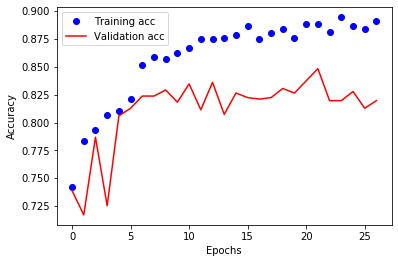

In [0]:
acc = history_finetunning.history['acc']
val_acc = history_finetunning.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# predict test data

In [0]:
test_datagen = ImageDataGenerator(rescale=1. / 128,  preprocessing_function=preprocess_image)

test_generator = test_datagen.flow_from_dataframe(dataframe=test,
                                                  directory="/content/test_images",
                                                  x_col="id_code",
                                                  target_size=(300, 300),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None)

Found 1928 validated image filenames.


In [0]:
y_test=np.argmax(model.predict(test_generator), axis=1)

In [0]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':y_test})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(50)

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,3
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,0
